In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.insert(1, '../')
import pandas as pd
import numpy as np
from IPython.display import clear_output
import random
import seaborn as sb
import matplotlib.pyplot as plt
from genetic_selection import GeneticSelectionCV
from sklearn.tree import ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report, make_scorer
from sklearn.utils.validation import check_consistent_length

In [3]:
def eval(X_train, y_train, X_test, y_test):
    model = MLPClassifier(hidden_layer_sizes=(128,128), activation="relu", solver="adam",
                          learning_rate="adaptive", learning_rate_init=0.0003, 
                          batch_size=64, max_iter=300, 
                          early_stopping=True, n_iter_no_change=30)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    print("\nClassification report:\n")
    print(classification_report(y_test, y_preds))
    print("\nConfusion matrix:\n")
    print(confusion_matrix(y_test, y_preds))

    return (
        accuracy_score(y_test, y_preds)*100,
        precision_score(y_test, y_preds, average="weighted")*100,
        recall_score(y_test, y_preds, average="weighted")*100,
        f1_score(y_test, y_preds, average="weighted")*100       
    )

In [4]:
df_train = pd.read_csv('../UNSW-NB15/cleaned_data/UNSW_NB15_training-set_cleaned.csv')
df_validation = pd.read_csv('../UNSW-NB15/cleaned_data/UNSW_NB15_validation-set_cleaned.csv')
df_test = pd.read_csv('../UNSW-NB15/cleaned_data/UNSW_NB15_testing-set_cleaned.csv')
X_train, y_train = df_train.iloc[:, 0:-2], df_train.iloc[:, -2]
X_validation, y_validation = df_validation.iloc[:, 0:-2], df_validation.iloc[:, -2]
X_test, y_test = df_test.iloc[:, 0:-2], df_test.iloc[:, -2]

In [5]:
def genetic_selector(n_population, X_train, y_train, use_validation_set=False, X_validation=None, y_validation=None, verbose=0):
    selector = GeneticSelectionCV(
        estimator=ExtraTreeClassifier(), 
        scoring=make_scorer(f1_score, average="weighted"),
        n_population=n_population, 
        n_generations=100, 
        n_gen_no_change=15, 
        verbose=verbose,
        n_jobs=-1
        )
    selector.fit(X_train, y_train, use_validation_set=use_validation_set, valid_X=X_validation, valid_y=y_validation)
    sel_features = sum([1 for support in selector.support_ if support])
    return selector, sel_features

In [6]:
result_df = pd.DataFrame(columns=["experiment", "pop_size", "features", "accuracy", "precision", "recall", "f1-score"])
sb.set_theme()

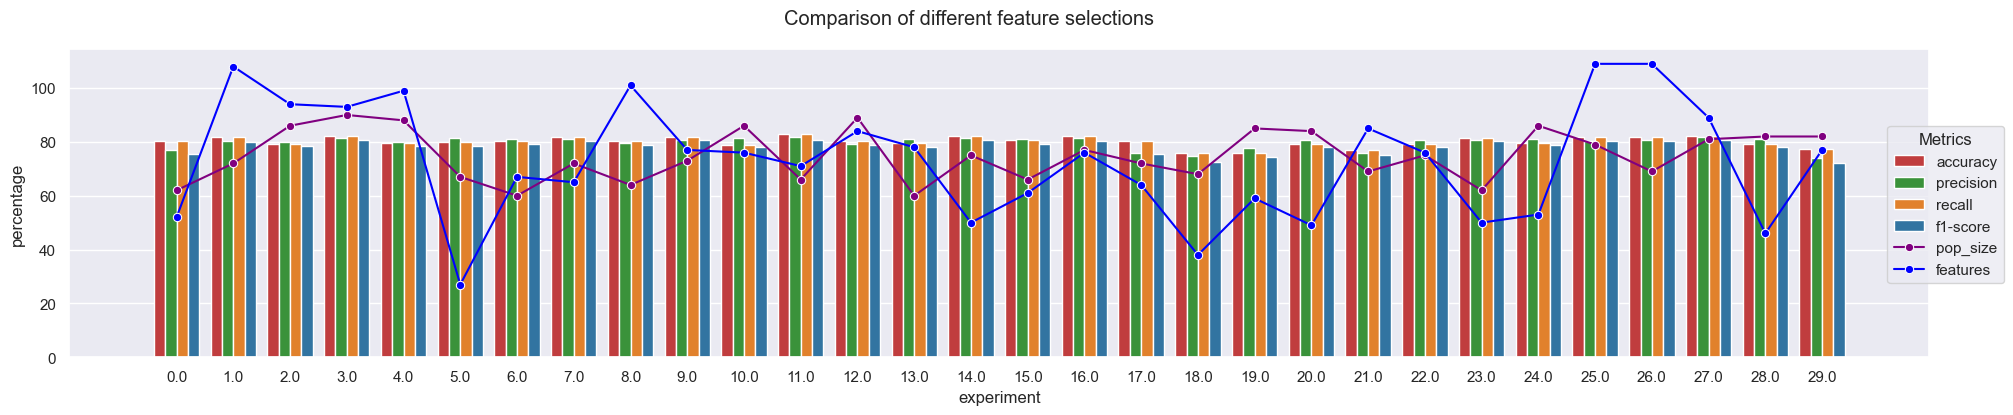

In [7]:
for i in range(30):
    n_population = random.randint(60, 90)
    validation_selector, sel_features = genetic_selector(n_population, X_train, y_train, use_validation_set=True, X_validation=X_validation, y_validation=y_validation, verbose=1)
    X_train_valid_selected = validation_selector.transform(X_train)
    X_test_valid_selected = validation_selector.transform(X_test)
    result_df.loc[len(result_df.index)] = [int(i), n_population, sel_features, *eval(X_train_valid_selected, y_train, X_test_valid_selected, y_test)]
    result_df

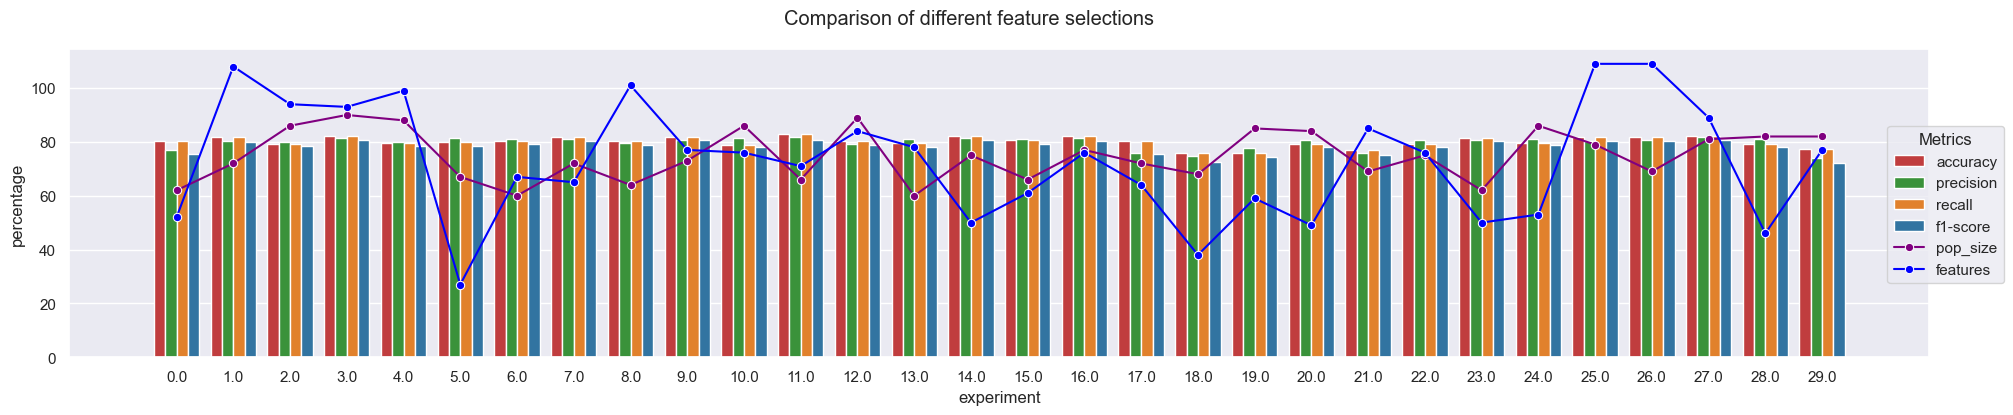

In [8]:
result_dfm = pd.melt(result_df, id_vars=("experiment"), value_vars=("accuracy", "precision", "recall", "f1-score"), var_name="metric", value_name="percentage")
fig, ax1 = plt.subplots(figsize=(24, 4))
fig.suptitle("Comparison of different feature selections")
sb.barplot(ax=ax1, data=result_dfm, x="experiment", y="percentage", hue="metric", palette=["tab:red", "tab:green", "tab:orange", "tab:blue"])
result_dfs = pd.melt(result_df, id_vars=("experiment"), value_vars=("pop_size", "features"), var_name="size", value_name="sizes")
sb.lineplot(ax=ax1, x="experiment", y="sizes", hue="size", data=result_dfs, palette=["purple", "blue"], marker='o')
ax1.legend(bbox_to_anchor=(1.04, 0.75), borderaxespad=0, title="Metrics")
plt.show()

In [9]:
result_df

,experiment,pop_size,features,accuracy,precision,recall,f1-score
0,0.0,62.0,52.0,80.510849,77.047278,80.510849,75.321721
1,1.0,72.0,108.0,81.872288,80.258618,81.872288,80.134843
2,2.0,86.0,94.0,79.295722,80.136443,79.295722,78.442824
3,3.0,90.0,93.0,82.078115,81.464007,82.078115,80.534851
4,4.0,88.0,99.0,79.499070,79.823954,79.499070,78.630320
5,5.0,67.0,27.0,80.014879,81.260256,80.014879,78.627762
6,6.0,60.0,67.0,80.188469,81.235992,80.188469,79.130903
7,7.0,72.0,65.0,81.976441,81.105843,81.976441,80.180768
8,8.0,64.0,101.0,80.488531,79.558232,80.488531,78.942097
9,9.0,73.0,77.0,81.941723,80.610848,81.941723,80.534055


In [10]:
result_df[["pop_size", "accuracy", "recall", "precision", "f1-score"]].describe()

,pop_size,accuracy,recall,precision,f1-score
count,30.00000,30.000000,30.000000,30.000000,30.000000
mean,74.90000,80.168547,80.168547,79.845503,78.361068
std,9.42246,1.863197,1.863197,2.187848,2.389070
min,60.00000,75.895846,75.895846,74.168508,72.121364
25%,67.25000,79.321141,79.321141,79.624662,78.105973
50%,74.00000,80.298822,80.298822,80.755978,78.797150
75%,83.50000,81.913205,81.913205,81.235283,80.198971
max,90.00000,82.827030,82.827030,81.916356,80.850808


In [1]:
result_df.to_csv('../output/test-2-result.csv', float_format='%f', index=False)

NameError: name 'result_df' is not defined